# Анализ тональности комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Цель проекта - обучить модель классифицировать комментарии на позитивные и негативные. В нашем распоряжении набор данных с разметкой о токсичности правок. Необходимо построить модель со значением метрики качества *F1* не меньше 0.75. 

**Структура проекта**

1. Загрузка и подготовка данных
2. Обучение моделей 
3. Выводы

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Загрузка данных

In [1]:
!pip install nltk -q
!pip install pymystem3 -q
!pip install spacy -q
!python -m spacy download en_core_web_sm
!pip install wordcloud -q

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.8.0/en_core_web_sm-3.8.0-py3-none-any.whl (12.8 MB)
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Установка библиотек
!pip install nltk -q
!pip install pymystem3 -q
!pip install spacy -q
!python -m spacy download en_core_web_sm -q
!pip install wordcloud -q

# Импорты

# --- Научные и визуализационные библиотеки ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- NLP и текстовая обработка ---
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from pymystem3 import Mystem
import spacy

# --- Машинное обучение ---
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

# --- Глубокое обучение ---
import torch
import transformers

# --- Прочее ---
from tqdm import notebook
from tqdm.notebook import tqdm
from wordcloud import WordCloud
import re

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
# Зададим переменные RANDOM_STATE и TEST_SIZE
RANDOM_STATE = 42
TEST_SIZE = 0.5

In [4]:
# Загрузим данные
try:
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    df = pd.read_csv('C:\\Users\pts12\\Downloads\\toxic_comments.csv', index_col=0)

In [5]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


Во входном датафрейме  з колонки и 159292 строки

## Анализ входных данных

In [7]:
# Проверка на пропуски
df.isna().sum()

text     0
toxic    0
dtype: int64

In [8]:
# Проверка полных дубликатов
df.duplicated().sum()

np.int64(0)

In [9]:
# Проверка дубликатов в колонке 'text'
df['text'].duplicated().sum()

np.int64(0)

In [10]:
# Процент единичек в колонке 'toxic'
df['toxic'].mean() * 100

np.float64(10.161213369158526)

C:\Users\pts12\AppData\Local\Temp\ipykernel_23292\4255028400.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


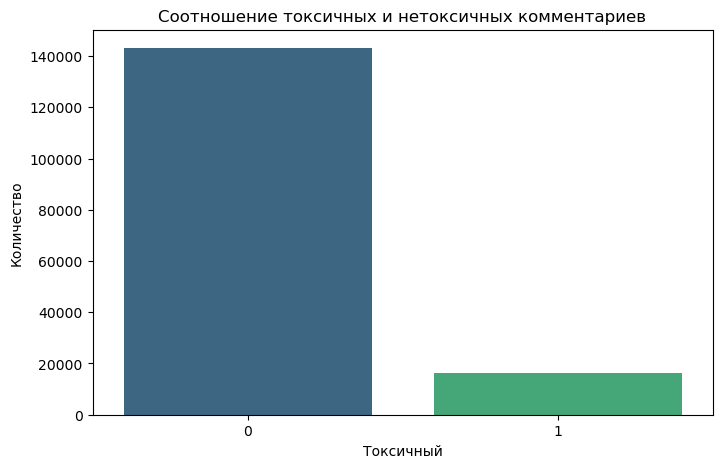

In [11]:
# выведем барплот для колонки 'toxic'
plt.figure(figsize=(8, 5))
sns.countplot(
data=df,
x='toxic',
palette='viridis'
)

plt.title('Соотношение токсичных и нетоксичных комментариев')
plt.xlabel('Токсичный')
plt.ylabel('Количество')
plt.show()

Дубликаты и пропуски в датафрейме отсутствуют. В целевом признаке 'toxic' наблюдается дисбаланс значений - количество единичек - 10 %, количество нулей - 90 %

In [12]:
# Количество слов в строке
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
# Количество символов в строке
df['char_count'] = df['text'].apply(lambda x: len(str(x)))

In [13]:
df.head()

,text,toxic,word_count,char_count
0,Explanation\nWhy the edits made under my usern...,0,43,264
1,D'aww! He matches this background colour I'm s...,0,17,112
2,"Hey man, I'm really not trying to edit war. It...",0,42,233
3,"""\nMore\nI can't make any real suggestions on ...",0,113,622
4,"You, sir, are my hero. Any chance you remember...",0,13,67


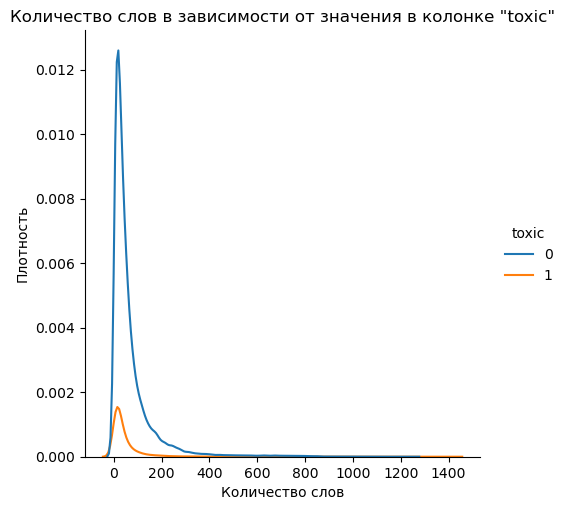

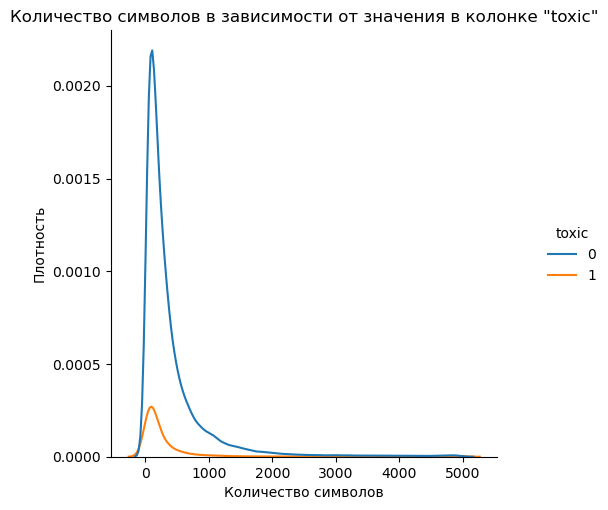

In [14]:
# Распределение количества символов и слов в зависимости от значения в колонке 'toxic'
sns.displot(data=df, x='word_count', hue='toxic',kind='kde')
plt.title(f'Количество слов в зависимости от значения в колонке "toxic"')
plt.xlabel('Количество слов')
plt.ylabel('Плотность')
plt.show()

sns.displot(data=df, x='char_count', hue='toxic', kind='kde')
plt.title(f'Количество символов в зависимости от значения в колонке "toxic"')
plt.xlabel('Количество символов')
plt.ylabel('Плотность')
plt.show()

    

In [15]:
df.query('toxic == 0')[['word_count', 'char_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
word_count,143106.0,68.857665,98.097420,1.0,18.0,37.0,78.0,1250.0
char_count,143106.0,403.956585,585.914845,6.0,102.0,216.0,452.0,5000.0


In [16]:
df.query('toxic == 1')[['word_count', 'char_count']].describe().T

,count,mean,std,min,25%,50%,75%,max
word_count,16186.0,52.677314,106.772843,1.0,11.0,23.0,50.00,1411.0
char_count,16186.0,302.932411,618.647890,5.0,61.0,128.0,282.75,5000.0


По графикам и статистике видно, что токсичные комментарии короче нетоксичных по количеству символов и слов. Среднее количество символов - 404 для нетоксичных комментариев и 303 для токсичных. Среднее количество слов - 69 для нетоксичных комментариев и 53 для токсичных.

In [17]:
# Загруска стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pts12\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [18]:
# Сэмплируем датафрейм для анализа с помощью облака слов
df_for_cloud = df.sample(n=10000, random_state=RANDOM_STATE)

In [19]:
# Функция для очистки текста (оставляем латинские буквы)
def clear_text(text):
    edited_text=re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(edited_text.split())

In [20]:
# Функция для лемматизации
nlp = spacy.load("en_core_web_sm")
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [21]:
df_for_cloud['text'] = df_for_cloud['text'].apply(clear_text).apply(lemmatize)

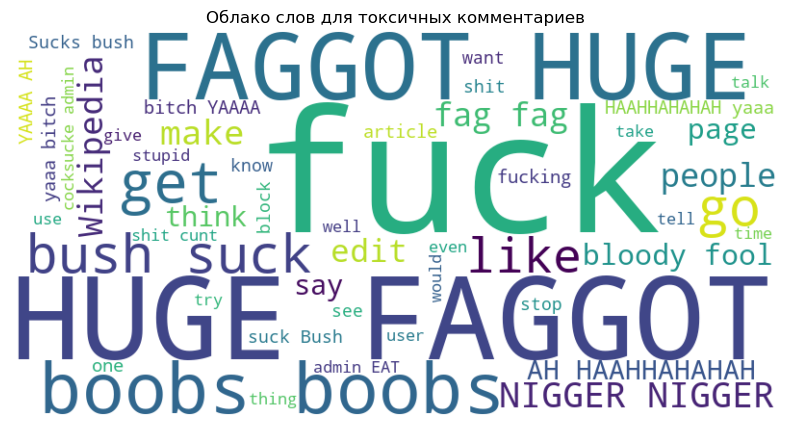

In [22]:
# Облако слов для токсичных комментариев
all_text = ' '.join(df_for_cloud.query('toxic == 1')['text'].astype(str))
wordcloud = WordCloud(
    width=800,          
    height=400,         
    background_color='white',  
    stopwords=stopwords,     
    max_words=50,      
    colormap='viridis'  
).generate(all_text)    

# Отображение
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Облако слов для токсичных комментариев')
plt.show()

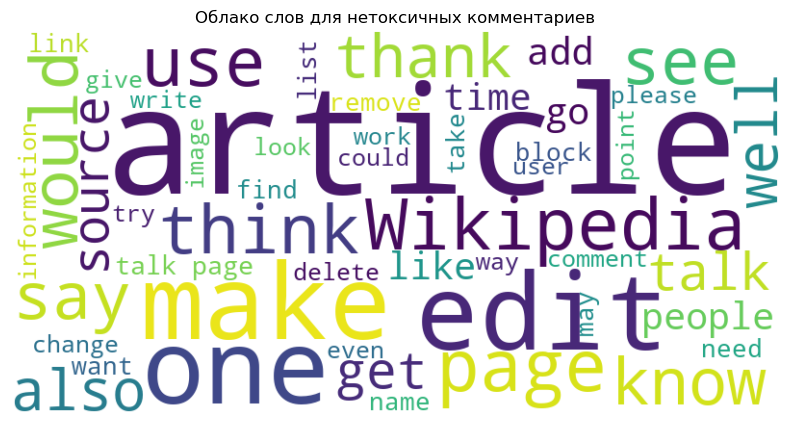

In [23]:
# Облако слов для нетоксичных комментариев
all_text = ' '.join(df_for_cloud.query('toxic == 0')['text'].astype(str))
wordcloud = WordCloud(
    width=800,          
    height=400,         
    background_color='white',  
    stopwords=stopwords,     
    max_words=50,      
    colormap='viridis'  
).generate(all_text)   

# Отображение
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов для нетоксичных комментариев')
plt.show()

Из облаков слов видны явные различия в наборе слов между токсичными и нетоксичными комментариями.

## Подготовка данных и обучение модели без BERT 

In [24]:
# Сэмплируем датафрейм для экономии времении
df_sampled = df.sample(n=100000, random_state=RANDOM_STATE)

In [25]:
# Функция для очистки текста (оставляем латинские буквы)
def clear_text(text):
    edited_text=re.sub(r'[^a-zA-Z ]', ' ', text)
    return " ".join(edited_text.split())

In [26]:
# Функция для лемматизации
nlp = spacy.load("en_core_web_sm")
def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

In [27]:
df_sampled['text'] = df_sampled['text'].apply(clear_text)

In [28]:
df_sampled.head(10)

,text,toxic,word_count,char_count
31055,Sometime back I just happened to log on to www...,0,177,937
102929,The latest edit is much better don t make this...,0,17,99
67385,October UTC I would think you d be able to get...,0,66,387
81167,Thanks for the tip on the currency translation...,0,13,73
90182,I would argue that if content on the Con in co...,0,83,467
1860,Reliable sources Cheating Barry Bonds Cheater ...,1,88,524
125422,WTF How The Fuck Does This Person Merit A Page...,1,12,62
149142,cajuns acadians Cajuns acadians louisianans th...,0,146,914
89784,Hi I dropped a pin in Google Maps at the cerem...,0,55,301
64323,Re removal of accessdate for urls books This i...,0,37,223


In [29]:
%%time
tqdm.pandas()
df_sampled['lemm'] = df_sampled['text'].progress_apply(lemmatize)

  0%|          | 0/100000 [00:00<?, ?it/s]

CPU times: total: 50min 6s
Wall time: 51min 47s


In [30]:
df_sampled.head(10)

,text,toxic,word_count,char_count,lemm
31055,Sometime back I just happened to log on to www...,0,177,937,sometime back I just happen to log on to www i...
102929,The latest edit is much better don t make this...,0,17,99,the late edit be much well don t make this art...
67385,October UTC I would think you d be able to get...,0,66,387,October utc I would think you d be able to get...
81167,Thanks for the tip on the currency translation...,0,13,73,thank for the tip on the currency translation ...
90182,I would argue that if content on the Con in co...,0,83,467,I would argue that if content on the Con in co...
1860,Reliable sources Cheating Barry Bonds Cheater ...,1,88,524,reliable source Cheating Barry Bonds Cheater f...
125422,WTF How The Fuck Does This Person Merit A Page...,1,12,62,WTF how the fuck do this Person Merit A Page o...
149142,cajuns acadians Cajuns acadians louisianans th...,0,146,914,cajun acadian Cajuns acadian louisianan they r...
89784,Hi I dropped a pin in Google Maps at the cerem...,0,55,301,hi I drop a pin in Google Maps at the ceremoni...
64323,Re removal of accessdate for urls books This i...,0,37,223,re removal of accessdate for url book this be ...


In [31]:
# Загруска стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pts12\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# Входной тектс и таргеты
features = df_sampled[['lemm', 'word_count']] 
targets = df_sampled['toxic']

In [33]:
# Разделим на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [34]:
data_preprocessor = ColumnTransformer(
    [
    ('tfidf', TfidfVectorizer(stop_words=list(stopwords)), 'lemm'),
     ('num', StandardScaler(), ['word_count'])   
    ]
)

In [35]:
# Инициализируем пайплайн
pipe= Pipeline([
    ('preproc', data_preprocessor),
    ('models', RandomForestClassifier(class_weight='balanced'))
]) 

In [36]:
# Создадим таблицу параметров (в моделях указываем class_weight='balanced')
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [RandomForestClassifier(class_weight='balanced')],
        'models__max_depth': [2, 5, 7],
        'models__n_estimators': [100, 200, 300],
        'preproc__tfidf__ngram_range': [(1, 1), (1, 2)],
    },
    {
        'models': [LogisticRegression(
            class_weight='balanced',
            random_state=RANDOM_STATE, 
        )],
        'models__C': range(1, 5),
        'preproc__tfidf__ngram_range': [(1, 1), (1, 2)],
    }    
    
]


In [37]:
grid = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

In [38]:
%%time
# Обучение моделей
grid.fit(X_train, y_train)

Fitting 5 folds for each of 26 candidates, totalling 130 fits
CPU times: total: 56.8 s
Wall time: 7min 48s


,estimator,Pipeline(step...'balanced'))])
,param_grid,"[{'models': [RandomForestC...ht='balanced')], 'models__max_depth': [2, 5, ...], 'models__n_estimators': [100, 200, ...], 'preproc__tfidf__ngram_range': [(1, ...), (1, ...)]}, {'models': [LogisticRegre...ndom_state=42)], 'models__C': range(1, 5), 'preproc__tfidf__ngram_range': [(1, ...), (1, ...)]}]"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('tfidf', ...), ('num', ...)]"


In [39]:
print('РЕЗУЛЬТАТЫ ОБУЧЕНИЯ МОДЕЛИ БЕЗ BERT:\n\n')
print('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('F1-score лучшей модели по кроссвалидационной выборке:', (grid.best_score_))

РЕЗУЛЬТАТЫ ОБУЧЕНИЯ МОДЕЛИ БЕЗ BERT:


Лучшая модель и её параметры:

 Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(ngram_range=(1,
                                                                               2),
                                                                  stop_words=['have',
                                                                              'shouldn',
                                                                              "they'll",
                                                                              'whom',
                                                                              'm',
                                                                              "didn't",
                                                                              'but',
                                                                       

In [40]:
# Предскажем целевой признак на тестовой выборке
y_test_pred = grid.predict(X_test)

In [41]:
print(f"F1-score на тестовой выборке (без BERT): {f1_score(y_test, y_test_pred ):.4f}")

F1-score на тестовой выборке (без BERT): 0.7686


Таким образом, лучший результат показала модель LogisticRegression(C=4, class_weight='balanced', random_state=42). Значения метрики f1 на кроссвалидационной и тестовой выборках равны, соответственно, 0.76 и 0.77 

## Подготовка данных и обучение модели с BERT 

In [42]:
# Сэмплируем датафрейм для экономии времении
df_sampled2 = df.groupby('toxic', group_keys=False).apply(lambda x: x.sample(frac=0.01, random_state=RANDOM_STATE))

C:\Users\pts12\AppData\Local\Temp\ipykernel_23292\4158176560.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled2 = df.groupby('toxic', group_keys=False).apply(lambda x: x.sample(frac=0.01, random_state=RANDOM_STATE))


In [43]:
df_sampled2.head()

,text,toxic,word_count,char_count
145956,"Press \n June 2011: Today Show, NBC: Today's M...",0,78,510
41086,Contested deletion \n\nThis article should not...,0,25,201
127657,"""\n Your latest edits have goen even further ...",0,126,759
5828,"""\nIt should not be deleted, but fixed. North ...",0,28,172
87827,I'm back... \n\n...I haven't found the rusty k...,0,32,179


In [44]:
df_sampled2.shape

(1593, 4)

In [45]:
# Проверка пропорции таргета
df_sampled2['toxic'].mean()

np.float64(0.1016949152542373)

In [46]:
# инициализируем токенизатор
tokenizer = transformers.AutoTokenizer.from_pretrained('unitary/toxic-bert')

tokenized = df_sampled2['text'].apply(
    lambda x: tokenizer.encode(
        x, 
        add_special_tokens=True, 
        max_length=512,        # Ограничиваем длину
        truncation=True         # Включаем усечение
    )
)
max_len = 512
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [47]:
# Загружаем предобученную моделль и ее конфигурацию
model = transformers.AutoModel.from_pretrained('unitary/toxic-bert')

In [48]:
batch_size = 100
embeddings = []

# Переносим модель на GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
    # Создаем батч
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
    
    # переносим данные  GPU
    batch = batch.to(device)
    attention_mask_batch = attention_mask_batch.to(device)
    
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
   
    embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

  0%|          | 0/15 [00:00<?, ?it/s]

In [49]:
# Объединим эмбеддинги для формирования входных признаков
features2 = np.concatenate(embeddings)

In [50]:
features2

array([[-0.6110636 , -0.9316078 ,  0.57790196, ..., -0.8421179 ,
         0.558296  ,  0.12744606],
       [-0.69004375, -0.85949254,  0.5881961 , ..., -0.76099545,
         0.38063154,  0.13037065],
       [-0.5803837 , -0.9301232 ,  0.6040815 , ..., -0.6812966 ,
         0.5559738 ,  0.13328488],
       ...,
       [-0.14806138, -0.07071487,  0.34225836, ..., -0.41574535,
         0.6085442 ,  0.59523165],
       [-0.353836  ,  0.64030194,  1.2193198 , ..., -0.23926279,
         0.22988611,  0.26249138],
       [-0.05970878, -0.28824306,  0.33233494, ..., -0.48227626,
         0.57215416,  0.20699608]], dtype=float32)

In [51]:
# Создадим датафрейм с входными признаками
df_features2 = pd.DataFrame(features2)

In [52]:
df_features2.shape

(1500, 768)

In [53]:
# Добавим признак "word_count"
df_features2['word_count'] = df_sampled2.reset_index()['word_count']

In [54]:
df_features2.shape

(1500, 769)

In [55]:
df_features2.head()

,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,word_count
0,-0.611064,-0.931608,0.577902,-0.344915,0.934994,0.306330,-0.184920,0.082020,-0.386819,-0.635274,...,-1.184989,0.243947,-0.741862,0.104109,0.892025,-0.513540,-0.842118,0.558296,0.127446,78
1,-0.690044,-0.859493,0.588196,-0.540250,1.112454,0.230303,-0.178099,-0.093250,-0.530705,-0.579027,...,-1.168496,0.394762,-0.721665,0.119353,0.741290,-0.448461,-0.760995,0.380632,0.130371,25
2,-0.580384,-0.930123,0.604082,-0.579745,1.018810,0.377650,-0.094141,0.005966,-0.472725,-0.781704,...,-1.204998,0.253688,-0.626601,0.133861,0.837837,-0.532259,-0.681297,0.555974,0.133285,126
3,-0.819980,-1.091491,0.414113,-0.420002,1.074104,0.162726,-0.192571,0.022397,-0.464167,-0.599290,...,-1.306526,0.264364,-0.735325,0.309083,0.867248,-0.648399,-0.779762,0.354160,0.122328,28
4,-0.697437,-0.754819,0.906266,-0.166939,0.635649,0.337357,0.796012,0.526732,-0.096041,0.356294,...,-0.099840,0.525626,-0.260755,-1.055853,-0.127267,-0.090680,-0.457731,0.526399,0.222725,32


In [56]:
df_features2.columns = df_features2.columns.astype(str)

In [57]:
# Задаем таргеты
targets2 = df_sampled2['toxic'].head(1500)

# Разделим датафрейм на тренировочную и тестовю выборки
X_train, X_test, y_train, y_test = train_test_split(df_features2, targets2, test_size=0.5, random_state=42)


In [58]:
data_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), ['word_count'])   
    ],
    remainder='passthrough'
)

In [59]:
# Инициализируем пайплайн
pipe2= Pipeline([
    ('preproc', data_preprocessor),
    ('models', RandomForestClassifier(class_weight='balanced')),
    
]) 

In [60]:
# Создадим таблицу параметров (в моделях указываем class_weight='balanced')
param_grid2 = [
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(class_weight='balanced')],
        'models__max_depth': range(2, 5, 7),
        'models__n_estimators': [100, 200, 300],
    },
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=RANDOM_STATE, 
        )],
        'models__C': range(1, 5),
    }    
]

In [61]:
grid2 = GridSearchCV(
    pipe2, 
    param_grid2, 
    cv=5, 
    scoring='f1',
    n_jobs=-1,
)

In [62]:
%%time
# Обучение моделей
grid2.fit(X_train, y_train)

CPU times: total: 1.36 s
Wall time: 36 s


,estimator,Pipeline(step...'balanced'))])
,param_grid,"[{'models': [RandomForestC...ht='balanced')], 'models__max_depth': range(2, 5, 7), 'models__n_estimators': [100, 200, ...]}, {'models': [LogisticRegre...ndom_state=42)], 'models__C': range(1, 5)}]"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...)]"


In [63]:
print('РЕЗУЛЬТАТЫ ОБУЧЕНИЯ МОДЕЛИ С BERT:\n\n')
print('Лучшая модель и её параметры:\n\n', grid2.best_estimator_)
print ('F1-score лучшей модели по кроссвалидационной выборке:', (grid2.best_score_))

РЕЗУЛЬТАТЫ ОБУЧЕНИЯ МОДЕЛИ С BERT:


Лучшая модель и её параметры:

 Pipeline(steps=[('preproc',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  ['word_count'])])),
                ('models',
                 RandomForestClassifier(class_weight='balanced', max_depth=2))])
F1-score лучшей модели по кроссвалидационной выборке: 0.878008658008658


In [64]:
# Предскажем целевой признак на тестовой выборке
y_test_pred2 = grid2.predict(X_test)

In [65]:
print(f"F1-score на тестовой выборке (c BERT): {f1_score(y_test, y_test_pred2 ):.4f}")

F1-score на тестовой выборке (c BERT): 0.9333


Таким образом, лучший результат показала модель LogisticRegression(C=1, class_weight='balanced', max_iter=1000, random_state=42). Значения метрики f1 на кроссвалидационной и тестовой выборках равны, соответственно, 0.87 и 0.93.

## Выводы

В данном проекте было выполнено обучение модели классификации с целью выявления токсичных комментариев.  
    
Во входном датафрейме содержится 159292 строки с текстом комментариев и целевой колонкой 'toxic'.  

Перед подготовкой данных была выполнена проверка на дубликаты и пропуски - выявлено не было. В целевом признаке "toxic" наблюдается дисбаланс значений - количество единичек - 10 %, количество нулей - 90 %.  

Подготовка данных к обучению моделей была выполнена в двух вариантах без BERT и с использованием BERT. В целях экономии времени в первом случае были выбраны в случайном порядке 100000 строк, во втором случае - 1500 строк.

**Обучение модели классификации без BERT**  

Лучший результат показала модель LogisticRegression(C=4, class_weight='balanced', random_state=42). Значения метрики f1 на кроссвалидационной и тестовой выборках равны, соответственно, 0.76 и 0.77.  

**Обучение модели классификации с BERT**  
Лучший результат показала модель RandomForestClassifier(class_weight='balanced', max_depth=2). Значения метрики f1 на кроссвалидационной и тестовой выборках равны, соответственно, 0.87 и 0.93.
